# Recommendation System with lightGCN

We are building a lightGCN recommendation system model, based on Prof's source code.

lightGCN is a **graph convolutional networks** that learns the representations of users and items through the user-item interaction graph, removing the nonlinear transformations and weights found in traditional graph convolutional networks. This simplification of the learning process allows the model to focus more on learning high-quality embeddings of users and items.

## Part 1: Data Loading and Exploration




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### To reproduce, make our submission folder a shortcut in your drive

In [ ]:
%cd /content/drive/My Drive/BT4222_Group_3_Submission

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import numpy as np
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
#Load Dataset
df = pd.read_csv("cleaned_datasets/train.csv")
full_df = pd.read_csv("cleaned_datasets/final_users_courses.csv")

#Select the columns (Reviewer, Course Name, Individual Rating, Date)
df = df[['Reviewer', 'Course Name', 'Individual Rating', 'Date']]

#Convert Date to Timestamp
df['Timestamp'] = pd.to_datetime(df['Date']).apply(lambda x: x.timestamp())

# Create a dictionary to map each unique reviewer to a unique numerical ID
unique_reviewers = full_df['Reviewer'].unique()
reviewer_to_id = {reviewer: i for i, reviewer in enumerate(unique_reviewers, start=1)}

# Create a new column 'user_id' and map the numerical IDs to the reviewers
df['user_id'] = df['Reviewer'].map(reviewer_to_id)

# Create a dictionary to map each unique reviewer to a unique numerical ID
unique_courses = full_df['Course Name'].unique()
course_name_to_id = {course: i for i,course in enumerate(unique_courses, start=1)}

# Create a new column 'user_id' and map the numerical IDs to the reviewers
df['item_id'] = df['Course Name'].map(course_name_to_id)

#Duplicate df
df_working_copy = df.copy()

#Drop Date column
df_working_copy = df_working_copy.drop(columns=['Date', 'Reviewer', 'Course Name'])

#Shift columns
df_working_copy = df_working_copy[['user_id', 'item_id', 'Timestamp', 'Individual Rating']]

#Rename columns
df_working_copy.columns = ['user_id', 'item_id', 'timestamp', 'rating']

df_working_copy.head()



,user_id,item_id,timestamp,rating
0,20574,131,1.589155e+09,5
1,20574,132,1.590365e+09,5
2,19220,131,1.585872e+09,5
3,19220,150,1.585872e+09,5
4,17175,159,1.567037e+09,5


In [ ]:
df = df_working_copy
df['rating'] = df['rating'].astype(np.float32)

In [ ]:
# Read testing set (eval)
test = pd.read_csv('cleaned_datasets/eval.csv')

In [ ]:
# Perform same preprocessing to test set

#Select the columns (Reviewer, Course Name, Individual Rating, Date)
test = test[['Reviewer', 'Course Name', 'Individual Rating', 'Date']]

#Convert Date to Timestamp
test['Timestamp'] = pd.to_datetime(test['Date']).apply(lambda x: x.timestamp())

# Create a new column 'user_id' and map the numerical IDs to the reviewers
test['user_id'] = test['Reviewer'].map(reviewer_to_id)

# Create a new column 'item_id' and map the numerical IDs to the reviewers
test['item_id'] = test['Course Name'].map(course_name_to_id)

#Duplicate df
test_working_copy = test.copy()

#Drop Date column
test_working_copy = test_working_copy.drop(columns=['Date', 'Reviewer', 'Course Name'])

#Shift columns
test_working_copy = test_working_copy[['user_id', 'item_id', 'Timestamp', 'Individual Rating']]

#Rename columns
test_working_copy.columns = ['user_id', 'item_id', 'timestamp', 'rating']

test_working_copy.head()

,user_id,item_id,timestamp,rating
0,20574,133,1.590538e+09,5
1,19220,133,1.585872e+09,5
2,17175,160,1.568160e+09,5
3,17176,195,1.584922e+09,4
4,21654,93,1.594512e+09,5


In [ ]:
test = test_working_copy
test['rating'] = test['rating'].astype(np.float32)

In [ ]:
train = df
test = test_working_copy
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  82090
Test Size :  26026


In [ ]:
# Use label encoding to transform user IDs and item IDs into integer indices for the training set
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print("Number of Users: ", len(train_user_ids), "\nNumber of Items: ", len(train_item_ids))

# Ensure that the test set only contains users and items that also appear in the training set
test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print("Number of matching users in test set: ", len(test))

Number of Users:  22575 
Number of Items:  234
Number of matching users in test set:  26022


In [ ]:
# Transform user IDs and item IDs in the test set using the label encoders fitted on the training set
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)
# Calculate the number of unique users and items in the training set
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  22575
Number of unique Items :  234


<ipython-input-150-be4d0ea08326>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['user_id_idx'] = le_user.transform(test['user_id'].values)
<ipython-input-150-be4d0ea08326>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['item_id_idx'] = le_item.transform(test['item_id'].values)


We define a function `convert_to_sparse_tensor`, aimed at converting sparse matrices into PyTorch's sparse tensor format. This is highly beneficial for handling large-scale user-item interaction data, as it significantly reduces memory usage. The function takes a dok_matrix (a sparse matrix in Dictionary of Keys format), converts it to COO (Coordinate format), and then further into a PyTorch sparse tensor.

- `latent_dim` is the length of the user/item embedding.

- `n_layers` is the number of times we want to propagate our initial user/item embedding through the graph

In [ ]:
# Set model hyperparameters: latent dimension and number of layers
latent_dim = 64  # Dimensionality of the latent feature space
n_layers = 3  # Number of layers in the neural network

import torch

# Define a function to convert a DOK matrix to a sparse tensor in PyTorch
def convert_to_sparse_tensor(dok_mtrx):
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)  # Convert DOK matrix to COO format and ensure data type
    values = dok_mtrx_coo.data  # Extract non-zero values
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## Part 2: Build the Metrics

Then we define a function to evaluate the performance of a recommendation system by comparing the model's top-K recommendations with the items actually interacted with by users in the test set. It provides insights into how well the model is able to recommend relevant items to users.



**Metrics**:

*   Recall: The fraction of relevant items that have been retrieved over the total amount of relevant items. It measures how many relevant items are successfully recommended.
*   Precision: The fraction of relevant items among the retrieved items. It measures the quality of the recommendation by evaluating how many of the recommended items are actually relevant.
* Hit List: A binary list indicating whether each of the top-K recommended items was interacted with by the user.
* NDCG (Normalized Discounted Cumulative Gain):	A measure of ranking quality that evaluates how well the recommended items are ranked based on their relevance. It accounts for the position of the relevant items in the recommendation list.
* MAP (Mean Average Precision): A measure of rank accuracy that considers the order of the recommendations and gives higher scores to hit items appearing earlier in the list.




In [ ]:
# Function to compute evaluation metrics for a recommendation system model
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    # Initialize user and item embeddings using pre-trained weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    # Get unique user IDs in the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # Initialize a sparse matrix R with interactions from the training data
    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    # Convert sparse matrix R to a sparse tensor
    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    # Add the relevance score matrix and the non-interacted items matrix
    relevance_score = relevance_score + R_tensor_dense

    # Retrieve the top-K relevance scores and their corresponding indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # Group the test set by user ID and retrieve the list of interacted items
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    # Check if each recommended item is in the interacted item list
    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]
    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
    def get_cumsum(hit_list):
        return np.cumsum(hit_list)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)
    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

## Part 3: Graph and Model Construction

### LightGCN Model

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        # Create adjacency matrix for the user-item graph
        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        # Normalize the adjacency matrix
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    # propagate user and item embeddings through the network for a specified number of layers
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    # define the forward pass of the model, compute the final embeddings for given users and items
    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [ ]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([22809, 64])


## Part 4: Model Traning and Evaluation

We first define the loss function used in training the model as `bpr_loss`. It computes Bayesian Personalized Ranking (BPR) loss and regularization loss:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn. BPR encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with L₂ regularization.
Positive items = Items that the user will interact with in the future.

### Defining loss function & data loader

In [ ]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    # Compute regularization loss
    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))

    # Compute scores for positive and negative items
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # Compute BPR loss using softplus function
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    # Randomly select users for batch training
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    # Select positive and negative items for each user
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

Now we are going to training the model.

Basically, for the training loop, we would consider the following steps:
- Initialize epoch-level variables such as loss and accuracy.
- Split the data into mini-batches and iterate over each batch.
- Forward pass: Pass the input data through the model to compute the predicted outputs.
- Compute the loss between the predicted outputs and the ground truth labels.
- Backward pass: Compute the gradients of the loss with respect to the model parameters.
- Update the model parameters using the optimization algorithm (e.g., gradient descent).
- Optionally, compute and track additional metrics such as accuracy, precision, recall, or F1-score.
- Repeat the above steps for all mini-batches in the training dataset.
- Compute the average loss and metrics for the epoch.

### Model training loop

In [ ]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

In [ ]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in range(EPOCHS):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in tqdm(range(n_batch)):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

### Performance of model

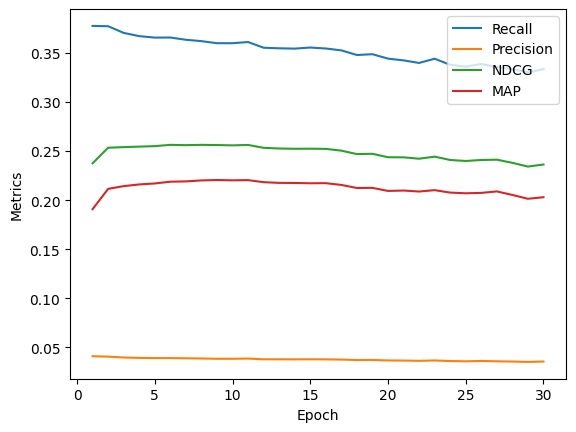

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

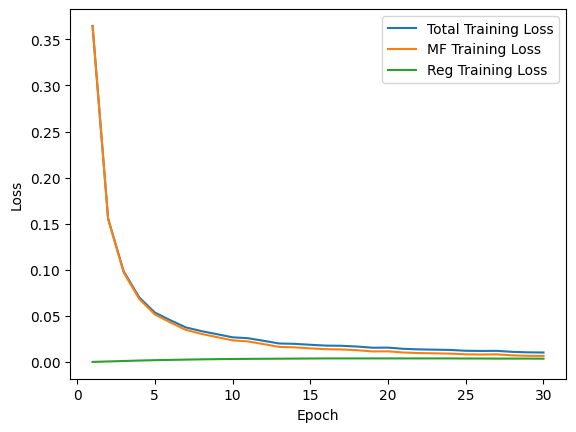

In [ ]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.3334
Last Epoch's Test Data Precision ->  0.0357
Last Epoch's Test Data NDCG ->  0.2363
Last Epoch's Test Data MAP ->  0.203
Last Epoch's Train Data Loss ->  0.0104


### Save model for future use

In [ ]:
torch.save(lightGCN.state_dict(), 'lightGCN.pth')

## Part 5: Making prediction & obtain scoring matrix

In [ ]:
score_matrix = torch.matmul(final_user_Embed, final_item_Embed.t())

In [ ]:
# Obtain id-to-user and id-to-course mappings

idx_to_user = {idx: user for user, idx in reviewer_to_id.items()}
idx_to_course = {idx: item for item, idx in course_name_to_id.items()}

In [ ]:
score_matrix_array = score_matrix.numpy()

In [ ]:
# Generate row and column labels from the inverted mappings
user_names = [idx_to_user[i+1] for i in range(score_matrix.size(0))]
item_names = [idx_to_course[j+1] for j in range(score_matrix.size(1))]

# Create the DataFrame
score_matrix_df = pd.DataFrame(score_matrix_array, index=user_names, columns=item_names)

In [ ]:
user_course_matrix = score_matrix_df.copy()

min_scores = user_course_matrix.min(axis=1)
max_scores = user_course_matrix.max(axis=1)

# Apply the normalization function to each row of the DataFrame
user_course_matrix = user_course_matrix.apply(lambda x: (x - min_scores[x.name]) / (max_scores[x.name] - min_scores[x.name]) if (max_scores[x.name] - min_scores[x.name]) != 0 else 0, axis=1)

In [ ]:
### Reading in train data

In [ ]:
train = pd.read_csv('cleaned_datasets/train.csv')

In [ ]:
# Get list of courses taken by users
courses_taken = train.groupby('Reviewer')['Course Name'].agg(list)
user_courses_map = courses_taken.to_dict()

In [ ]:
# Set probability of taken courses being recommended again to 0
for reviewer, courses in user_courses_map.items():
    if reviewer in user_course_matrix.index:
        for course in courses:
            if course in user_course_matrix.columns:
                user_course_matrix.at[reviewer, course] = 0

### Fill in missing courses (removed due to lack of user interactions in lightGCN training)

In [ ]:
# Create a dictionary to map each unique reviewer to a unique numerical ID
unique_courses = full_df['Course Name'].unique()
course_name_to_id = {course: i for i,course in enumerate(unique_courses, start=1)}

# Get the column names from your current matrix
current_columns = set(user_course_matrix.columns)

# Get the course names from the dictionary keys
course_names_from_dict = set(course_name_to_id.keys())

# Find the missing column names
missing_column_names = course_names_from_dict - current_columns

# Convert the missing column names to a list
missing_column_names_list = list(missing_column_names)

#For each missing itemID, add a column
for course in missing_column_names_list:
    user_course_matrix[course] = 0

user_course_matrix

,child nutrition and cooking,budgeting and scheduling projects,successful negotiation: essential strategies and skills,initiating and planning projects,chinese for beginners,terrorism and counterterrorism: comparing theory and practice,dog emotion and cognition,introductory human physiology,introduction to negotiation: a strategic playbook for becoming a principled and persuasive negotiator,management of fashion and luxury companies,...,high stakes leadership: leading in times of crisis,excel fundamentals for data analysis,natural language processing with probabilistic models,fundamentals of finance,web application technologies and django,social work practice: advocating social justice and change,natural language processing with sequence models,fundamentals of machine learning for healthcare,natural language processing with attention models,how to manage a remote team
lorenia a,0.000000,0.134688,0.162200,0.175117,0.287961,0.241403,0.225533,0.216163,0.241251,0.246740,...,0.210531,0.233290,0.216189,0.204113,0.211075,0,0,0,0,0
vijayakumar m n,0.082545,0.000000,0.165609,0.000000,0.219407,0.302799,0.029305,0.228948,0.158657,0.374027,...,0.139594,0.062231,0.105704,0.130891,0.119619,0,0,0,0,0
swati s,0.377398,0.243279,0.000000,0.292908,0.281888,0.306184,0.242237,0.220365,0.316620,0.209638,...,0.039302,0.026867,0.141578,0.105979,0.129989,0,0,0,0,0
camila g,0.554261,0.284639,0.286286,0.300306,0.000000,0.361328,0.372877,0.284146,0.130250,0.252206,...,0.241681,0.194186,0.188289,0.208586,0.209968,0,0,0,0,0
monica d,0.000000,0.163642,0.212423,0.279893,0.385112,0.234334,0.269978,0.144002,0.219352,0.280769,...,0.089427,0.139876,0.139047,0.132104,0.144978,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ghislain f,0.130698,0.125103,0.140309,0.074595,0.158133,0.130245,0.110225,0.181650,0.092013,0.085073,...,0.124212,0.130035,0.113484,0.116204,0.129861,0,0,0,0,0
ritik r s,0.127908,0.032642,0.342155,0.041434,0.258269,0.219958,0.217024,0.054790,0.131703,0.127218,...,0.164354,0.153186,0.137275,0.138228,0.144545,0,0,0,0,0
juan d j c,0.123932,0.044190,0.041182,0.026339,0.041486,0.035837,0.078973,0.067317,0.028512,0.112531,...,0.082263,0.105541,0.128479,0.088322,0.095776,0,0,0,0,0
rama c s,0.078509,0.105128,0.135381,0.187606,0.097186,0.099121,0.184990,0.003339,0.168071,0.057208,...,0.130052,0.079791,0.142427,0.151970,0.136915,0,0,0,0,0


In [ ]:
### Reading in test data

In [ ]:
test_df = pd.read_csv('cleaned_datasets/test.csv', index_col=0)

In [ ]:
# Group by 'Reviewer' and aggregate the courses into a list
actual_courses = test_df.groupby('Reviewer')['Course Name'].agg(list)

In [ ]:
top_n = 10

In [ ]:
# Top 10 recommendations for each user
top_n_recs = user_course_matrix.apply(lambda x: list(x.nlargest(top_n).index), axis=1)

### Evaluating the recommendation made on train/test set

In [ ]:
def evaluate_recommendations(recommendations, actual):
    """
    Evaluate recommendations using precision and recall for named reviewers.

    :param recommendations: Pandas Series where index is reviewer names and values are lists of recommended courses.
    :param actual: Pandas Series where index is reviewer names and values are lists of actual courses.
    :returns: Tuple containing average precision and recall for all reviewers.
    """
    precision_list = []
    recall_list = []

    # Iterate over each reviewer's recommendations and actual courses
    for reviewer, recs in recommendations.items():
        acts = actual.get(reviewer, [])
        true_positives = set(recs) & set(acts)

        precision = len(true_positives) / len(recs) if recs else 0
        recall = len(true_positives) / len(acts) if acts else 0

        precision_list.append(precision)
        recall_list.append(recall)

    average_precision = sum(precision_list) / len(precision_list) if precision_list else 0
    average_recall = sum(recall_list) / len(recall_list) if recall_list else 0

    return average_precision, average_recall

In [ ]:
precision, recall = evaluate_recommendations(top_n_recs, actual_courses)
f1_score = 2 * (precision * recall) / (precision + recall)
# Print the results
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {round(f1_score, 4)}")

Precision: 0.02412846068660266, Recall: 0.2227666716132614, F1 Score: 0.0435


### Export scoring matrix for hybrid model (uncomment to run)

In [ ]:
user_course_matrix.to_csv('score_matrices/scoring_matrix_lightgcn.csv')

### Sample prediction using lightGCN model

In [ ]:
sample_user = "shreya v"

# Get the top 10 recommendations for the sample user
sample_user_recs = top_n_recs[sample_user]
print(f"Course taken by {sample_user}:\n{user_courses_map[sample_user]}")
print(f"Top 5 Recommendations for {sample_user}:")

for recc in  sample_user_recs[:5]:
    print(recc)

Course taken by shreya v:
['introduction to machine learning']
Top 5 Recommendations for shreya v:
ai for everyone
programming for everybody getting started with python
design and interpretation of clinical trials
inspiring and motivating individuals
successful negotiation: essential strategies and skills
